In [1]:
import os
import matplotlib.image as img 
import numpy as np 
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
 def detect_faces(cascade, test_image):
    # create a copy of the image to prevent any changes to the original one.
    image_copy = test_image.copy()

    #convert the test image to gray scale as opencv face detector expects gray images
    gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)

    # Applying the haar classifier to detect faces
    faces_rect = cascade.detectMultiScale(gray_image, scaleFactor=1.3,minNeighbors=3,minSize=(30, 30))

    for (x, y, w, h) in faces_rect:
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0))
        image_copy = image_copy[y:y + h, x:x + w]
        try:
            image_copy = cv2.resize(image_copy, (250,250))
            return image_copy
        except:
            continue;


def process_data(folder): 
    gender = "";                                
    images = []; 
    haar_cascade_face = cv2.CascadeClassifier('./data/haarcascade_frontalface_default.xml')
    for subdir, dirs, files in os.walk(folder):
        if("male" in subdir):
            if ("female" in subdir):
                gender = "female"
            else:
                gender = "male"
        for f in files:
            d = {};
            img = cv2.imread(os.path.join(subdir,f))
            if img is not None:
                img = detect_faces(haar_cascade_face, cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                if img is not None:
                    d["name"] = f
                    d["gender"] = gender
                    d["image"] = img
                    images.append(d)
    return images


path = "./data/faceScrubImg"
img_info = process_data(path)

In [14]:
for i in img_info:
    if i["gender"] == "male":
        cv2.imwrite('./data/faceScrubCropped/male/'+i["name"], cv2.cvtColor(i["image"], cv2.COLOR_BGR2RGB))
    else:
        cv2.imwrite('./data/faceScrubCropped/female/'+i["name"], cv2.cvtColor(i["image"], cv2.COLOR_BGR2RGB))

In [15]:
counter = 0;
for i in img_info:
    if i["gender"] == "male":
        counter += 1
print(counter)

print(img_info[1]["image"].shape)

3544
(250, 250, 3)


In [16]:
labels = ["male", "female"]

males, females = [], [];
male_labels, female_labels = [], []

for info in img_info:
    if(info["gender"]=="male"):
        males.append(info["image"])
        male_labels.append(labels.index(info["gender"]))
    else:
        females.append(info["image"])
        female_labels.append(labels.index(info["gender"]))
    
# grab random 3544 women from the data set
rand_females = random.sample(females, 3544) 
rand_labels = random.sample(female_labels, 3544)

images, all_labels = np.array(rand_females+males), np.array(rand_labels+male_labels)
train_images, test_images, train_labels, test_labels = train_test_split(images, all_labels, train_size=0.5,test_size=0.5)
train_labels = train_labels.reshape(3544, 1)
test_labels = train_labels.reshape(3544, 1)

In [17]:
# print what percentage of males vs females
num_females = 0;
counter = 0;
for g in train_labels:
    num_females = g[0] + num_females
    
print("Percentage of females in training data set:", (num_females/(len(train_labels)))*100)

Percentage of females in training data set: 50.0


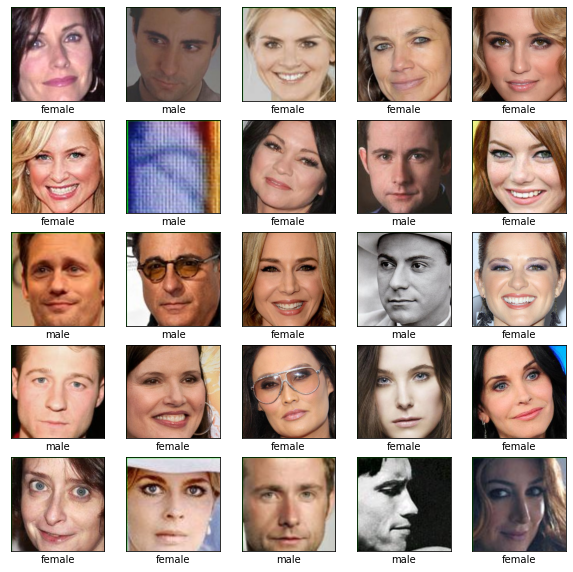

In [18]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(labels[train_labels[i][0]])
plt.show()

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 64)        36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 222784)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
111/111 [==============================] - 112s 1s/step - loss: 87.6309 - accuracy: 0.5745 - val_loss: 0.7181 - val_accuracy: 0.5087
Epoch 2/10
111/111 [==============================] - 109s 981ms/step - loss: 0.6504 - accuracy: 0.6560 - val_loss: 0.7605 - val_accuracy: 0.4966
Epoch 3/10
111/111 [==============================] - 108s 976ms/step - loss: 0.5262 - accuracy: 0.7492 - val_loss: 0.9724 - val_accuracy: 0.4848
Epoch 4/10
111/111 [==============================] - 108s 973ms/step - loss: 0.5006 - accuracy: 0.7692 - val_loss: 1.1327 - val_accuracy: 0.4904
Epoch 5/10
111/111 [==============================] - 115s 1s/step - loss: 0.4643 - accuracy: 0.7889 - val_loss: 1.5326 - val_accuracy: 0.4927
Epoch 6/10
111/111 [==============================] - 115s 1s/step - loss: 0.4798 - accuracy: 0.7709 - val_loss: 1.1333 - val_accuracy: 0.5048
Epoch 7/10
111/111 [==============================] - 114s 1s/step - loss: 0.4537 - accuracy: 0.7822 - val_loss: 1.4194 - val_accura

111/111 - 22s - loss: 3.1506 - accuracy: 0.5034


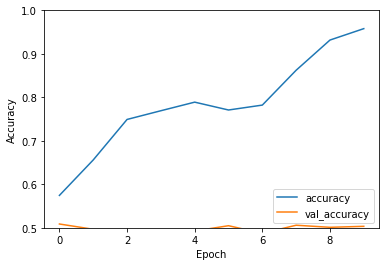

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [26]:
print(test_acc)

0.5033860206604004
